In [2]:
# Necessary imports

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

path = '../Data/GDC_Data/'

In [3]:
'''
We need to be able to determine which files are associated with
a given patient. The json file contains this information. Here
we are storing all the metadata.
'''

with open('../Data/GDC_Metadata.json') as file:
    json_string = file.readlines()
    json_string = ''.join(json_string)
metadata = json.loads(json_string)

'''
Making a dictionary where each key is the Case ID, and the value
is a list of the files associated with each patient.
'''

# Dictionary of Case IDs
case_id_dict = {}

# For each entry in the metadata from the json file
for entry in metadata:
    
    # Getting the case ID
    case_id = entry['associated_entities'][0]['case_id']
    # Getting the associated file name
    file_name = entry['file_name']
    
    # If the Case ID is already in the dictionary, add the file
    # name to the list of values
    if case_id in case_id_dict:
        case_id_dict[case_id].append(file_name)
    # If not already in the dictionary, add new key and value
    else:
        case_id_dict[case_id] = [file_name]


# List of Case IDs that have the right number of files
tumor_case_ids = []

# For each Case ID
for key in case_id_dict:
    # If they have 2 files, add them to the list of files to use
    if len(case_id_dict[key]) == 2:
        tumor_case_ids.append(key)


In [4]:
#Create miRNA matrix for tumor samples 
cases = tumor_case_ids  #[0:num_patients]

mirna_cancer= np.empty((0, 1881))
# For each patient
for case in cases:
    # Get their case files
    case_files = case_id_dict[case]
    for file in case_files:
        # Get the microRNA file
        if file[-1] == 't':
            case_file_mrna = path + file
            # Load the microRNA file as an array
            mrnas = np.loadtxt(case_file_mrna, dtype='str')
            # Removing the column titles
            mrnas = np.delete(mrnas, 0, 0)
            col_num= len(mrnas[:,1])
            reads= np.reshape(mrnas[:,1], (1, col_num))
            mirna_cancer= np.append(mirna_cancer, reads, axis=0)

In [5]:
#Make miRNA matrix for normal samples 
# open normal data
#for file in gdc_normal
#if ends in t, extract it and append to matrice 
normal_miRNA= np.empty((0,1881))
path_normal = '../Data/GDC_Normal_Data/'
import os
for filename in os.listdir(path_normal):
   if filename[-1] == 't':
      #print(filename)
      filepath= path_normal + filename
      mrnas = np.loadtxt(filepath, dtype='str')
      mrnas = np.delete(mrnas, 0, 0)
      col_num= len(mrnas[:,1])
      reads= np.reshape(mrnas[:,1], (1, col_num))
      normal_miRNA= np.append(normal_miRNA, reads, axis=0)
      # Removing the column titles
      #mrnas = np.delete(mrnas, 0, 0)

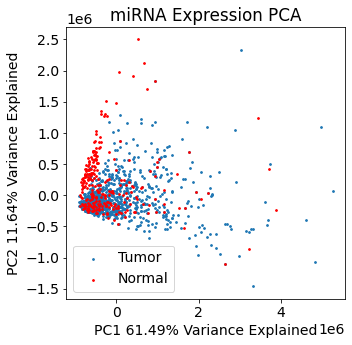

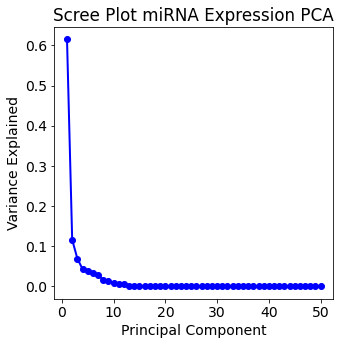

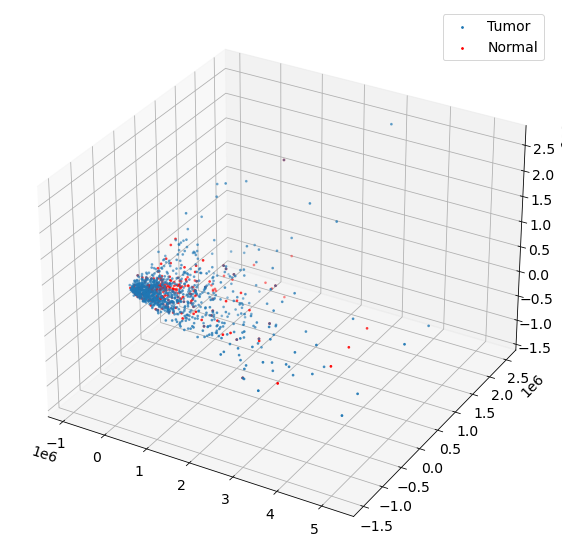

In [12]:
#concatenate normal and cancer miRNA
mirna_combined= np.concatenate((mirna_cancer, normal_miRNA), axis=0)

#Perform pca on miRNA data
from sklearn.decomposition import PCA
pca= PCA(n_components=50)
reduced_miRNA=pca.fit_transform(mirna_combined)

#plot first two dimensions of pca 
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 14})
split_index= np.shape(mirna_cancer)[0]
ax.scatter(reduced_miRNA[0:split_index,0], reduced_miRNA[0:split_index,1], s=3, label='Tumor') 
ax.scatter(reduced_miRNA[split_index::,0], reduced_miRNA[split_index::,1], color='red', s= 3, label='Normal')
ax.set_xlabel("PC1 {:.2f}% Variance Explained".format(pca.explained_variance_ratio_[0]*100, 3))
ax.set_ylabel("PC2 {:.2f}% Variance Explained".format(pca.explained_variance_ratio_[1]*100, 3))
ax.set_title("miRNA Expression PCA")
ax.legend()

#Create a Scree Plot
fig, ax = plt.subplots(figsize=(5,5))
PC_values = np.arange(pca.n_components_) + 1
ax.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
ax.set_title('Scree Plot miRNA Expression PCA')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained')

#Plot first 3 pcs
#fig, ax = plt.subplots(figsize=(5,5))
fig = plt.figure(figsize = (20, 10))
ax = plt.axes(projection ="3d")
split_index= np.shape(mirna_cancer)[0]
ax.scatter3D(reduced_miRNA[0:split_index,0], reduced_miRNA[0:split_index,1],reduced_miRNA[0:split_index,2], s=3, label='Tumor') 
ax.scatter3D(reduced_miRNA[split_index::,0], reduced_miRNA[split_index::,1], reduced_miRNA[split_index::,2], color='red', s= 3, label='Normal')
ax.legend()


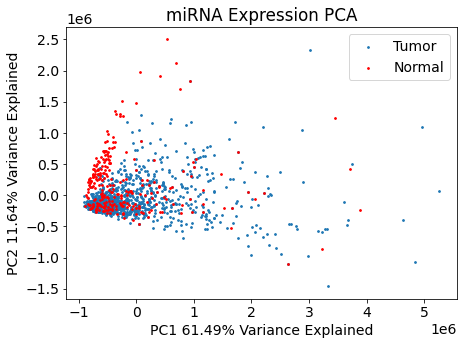

In [26]:
#Make figure of first two pcs
fig, ax = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 14})
split_index= np.shape(mirna_cancer)[0]
ax.scatter(reduced_miRNA[0:split_index,0], reduced_miRNA[0:split_index,1], s=3, label='Tumor') 
ax.scatter(reduced_miRNA[split_index::,0], reduced_miRNA[split_index::,1], color='red', s= 3, label='Normal')
ax.set_xlabel("PC1 {:.2f}% Variance Explained".format(pca.explained_variance_ratio_[0]*100, 3), size=14)
ax.set_ylabel("PC2 {:.2f}% Variance Explained".format(pca.explained_variance_ratio_[1]*100, 3), size=14)
ax.set_title("miRNA Expression PCA")
ax.legend()
plt.savefig('PCAv4.jpg', dpi=200)

In [30]:
#Random forest classifier 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
# models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# metrics 
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

#make y list, 1 if tumor, 0 if normal sample 
y=[]
for i in range(len(mirna_cancer)):
    y.append(1)
for j in range(len(normal_miRNA)):
    y.append(0)
X= mirna_combined

#split into testing and training sets
X, y= shuffle(X, y)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

#scale data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

#fit random forest
model= RandomForestClassifier().fit(X_train_scaled, y_train)

#ROC score
train_auc= roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:,1])
test_auc= roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])
print(train_auc)
print(test_auc)

#Calculate confusion matrix
y_pred= model.predict(X_test_scaled)
cf_matrix = confusion_matrix(y_test, y_pred)


0.9982209043736101
0.6858377659574468


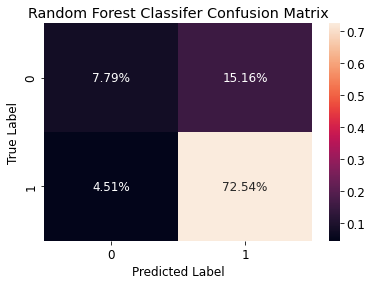

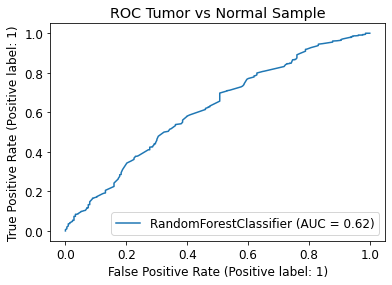

In [31]:
#Plot confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

ax = plt.axes()
plt.rcParams.update({'font.size': 12})
p=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', ax=ax)
ax.set_title('Random Forest Classifer Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()
p.figure.savefig('confusionmatrixv2.jpg', dpi=200)


In [39]:
#Use cross validation to obtain performance metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline

model= RandomForestClassifier()
scaler = preprocessing.StandardScaler()
#model = RandomForestClassifier(max_depth=2, n_estimators=20)
pipeline = Pipeline([('scaler', scaler), ('model', model)])

# Cross validation on 10 different test train splits
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scoring=['roc_auc', 'accuracy', 'precision', 'recall']
scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
#accuracy= cross_val_score(model2, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC : %.3f' % np.mean(scores['test_roc_auc']))
print('Std ROC AUC : %.3f' % np.std(scores['test_roc_auc']))
print('Accuracy : %.3f' % np.mean(scores['test_accuracy']))
print('Accuracy std: %.3f' % np.std(scores['test_accuracy']))

print('Precision : %.3f' % np.mean(scores['test_precision']))
print('Precision std: %.3f' % np.std(scores['test_precision']))

print('Recall : %.3f' % np.mean(scores['test_recall']))
print('Recall std: %.3f' % np.std(scores['test_recall']))

Mean ROC AUC : 0.661
Std ROC AUC : 0.065
Accuracy : 0.825
Accuracy std: 0.022
Precision : 0.843
Precision std: 0.016
Recall : 0.953
Recall std: 0.020


In [ ]:
#Extract feature importances 
feat_importances= model.feature_importances_
feat_importances= np.reshape(feat_importances, (1881,1))
print(feat_importances)

#get gene names
ex_file="0b9ec0ab-16db-4d45-bb15-0e37f6b666a1.mirbase21.mirnas.quantification.txt"
path_normal = '../Data/GDC_Normal_Data/'
filepath= path_normal + ex_file
ex_data=np.loadtxt(filepath, dtype='str')
ex_data = np.delete(ex_data, 0, 0)
gene_names= np.reshape(ex_data[:,0], (1881,1))

#concatenate gene names with feature importances, save as csv
gene_importances=np.concatenate((gene_names, feat_importances), axis=1)
print(gene_importances)
gene_importance_df= pd.DataFrame(gene_importances)
gene_importance_df.to_csv('miRNA_importances.csv', index=False, header=False, sep=',')

Text(0.5, 1.0, 'ROC Tumor vs Normal Sample')

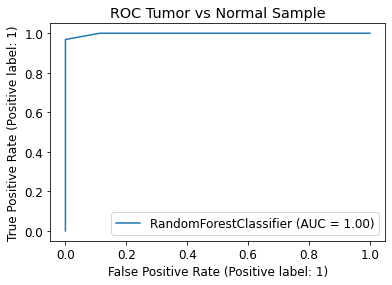

In [37]:
#Make ROC of training data
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
model.fit(X_train_scaled, y_train)
RocCurveDisplay.from_estimator(model, X_train_scaled, y_train)
plt.title('ROC Tumor vs Normal Sample')